<a href="https://colab.research.google.com/github/Loudni-s/ClosedOverlap/blob/master/notebooks/Interacting_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41934 sha256=ce00f21233e5e1a5c3e84204d651ae0c17403484418c330c69ebae7297ca7003
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tbmjxrgj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-tbmjxrgj
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369080 sha256=9059060f3a406b8268cfcbbf03647ab9b59e660d03f86c6120a9dd06f2b82cec
  Stored in directory: /tmp/pip-ephem-wheel-cache-7v3mrcvj/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.9.0+cu102


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.0MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f3a24ffb440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

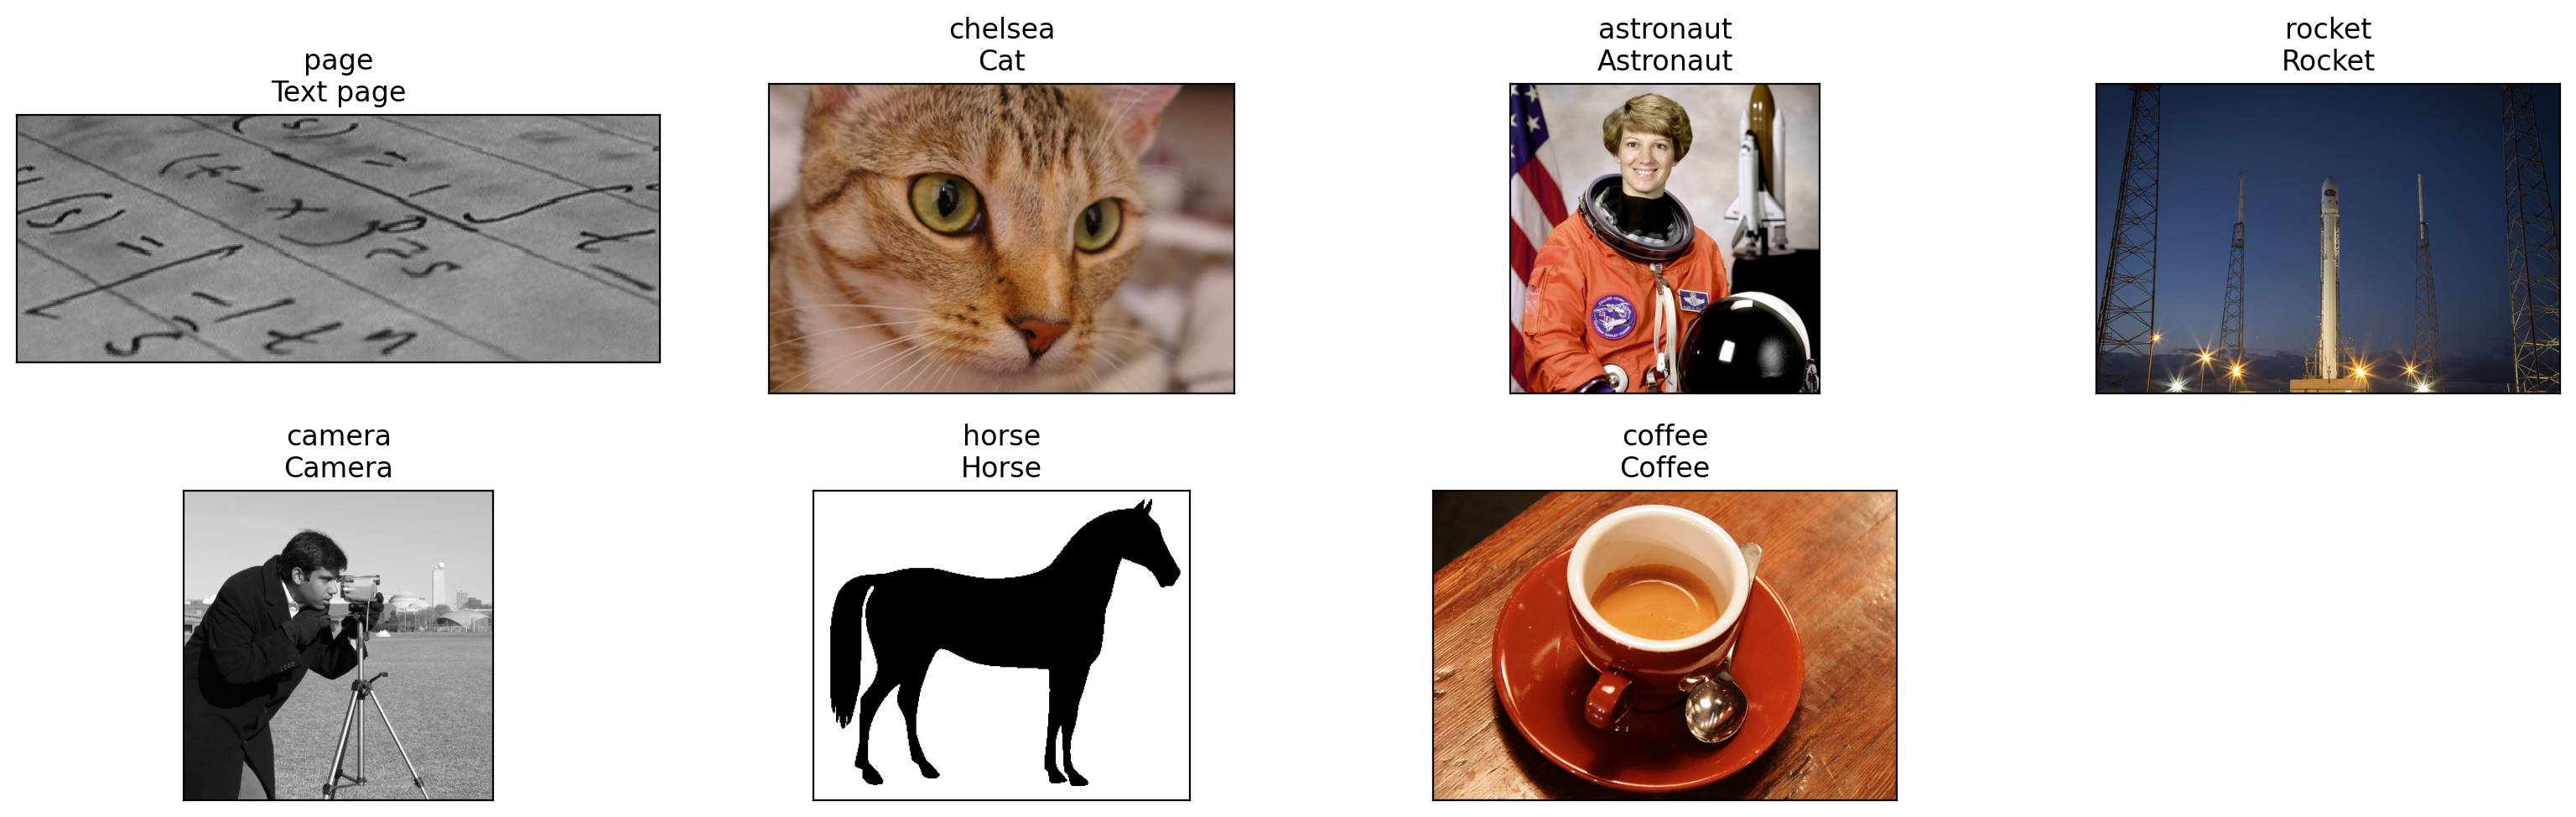

In [28]:
import requests
import io
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import skimage.data

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

# Define a mapping from the description keys to the actual skimage data functions
# Note: 'text' is the function for 'page' image in skimage.data
image_loader_functions = {
    "page": skimage.data.text,
    "chelsea": skimage.data.chelsea,
    "astronaut": skimage.data.astronaut,
    "rocket": skimage.data.rocket,
    "camera": skimage.data.camera,
    "horse": skimage.data.horse,
    "coffee": skimage.data.coffee
}

# Assuming descriptions is defined elsewhere in your code
# If not, you need to define it before this loop
descriptions = {
    "page": "Text page",
    "chelsea": "Cat",
    "astronaut": "Astronaut",
    "rocket": "Rocket",
    "camera": "Camera",
    "horse": "Horse",
    "coffee": "Coffee"
}

for i, (name, desc_text) in enumerate(descriptions.items()):
    if name in image_loader_functions:
        np_image = image_loader_functions[name]()
        image = Image.fromarray(np_image).convert("RGB")
    else:
        print(f"Warning: No specific loader for image '{name}'. Skipping.")
        continue

    plt.subplot(2, 4, i + 1) # Subplot index starts from 1
    plt.imshow(image)
    plt.title(f"{name}\n{desc_text}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(desc_text)

plt.tight_layout()
plt.show()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [31]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [32]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [33]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

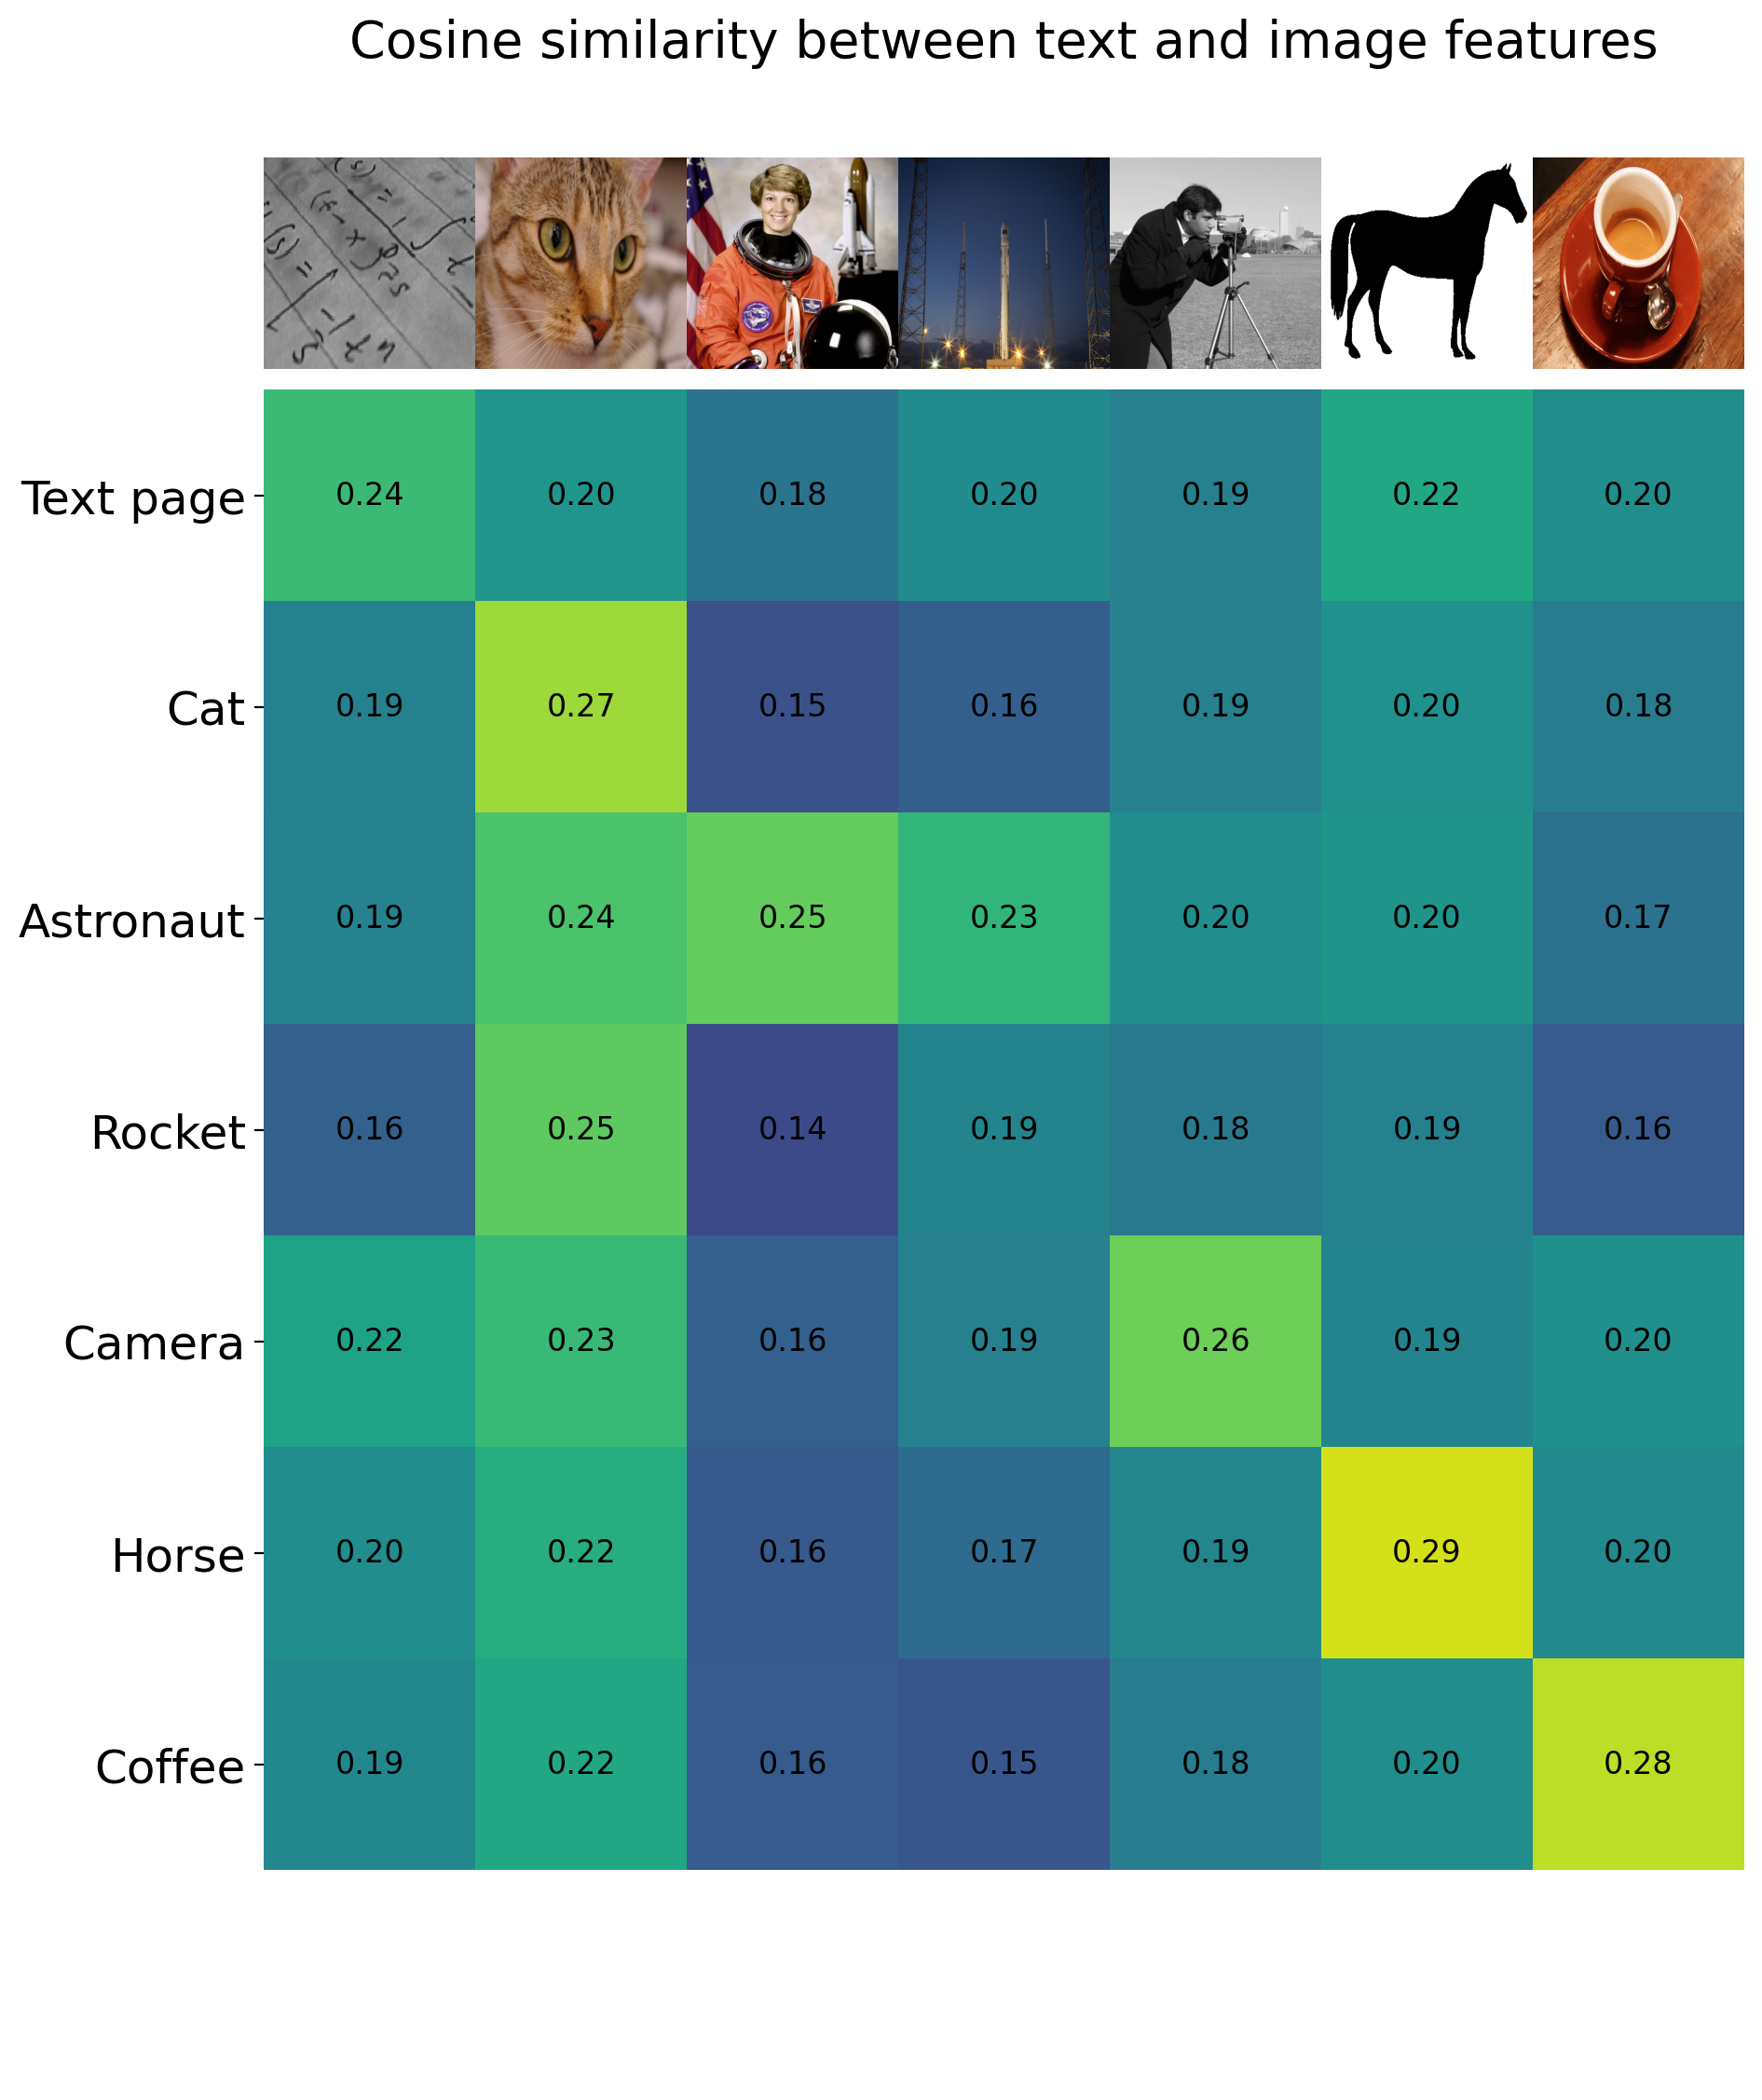

In [34]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

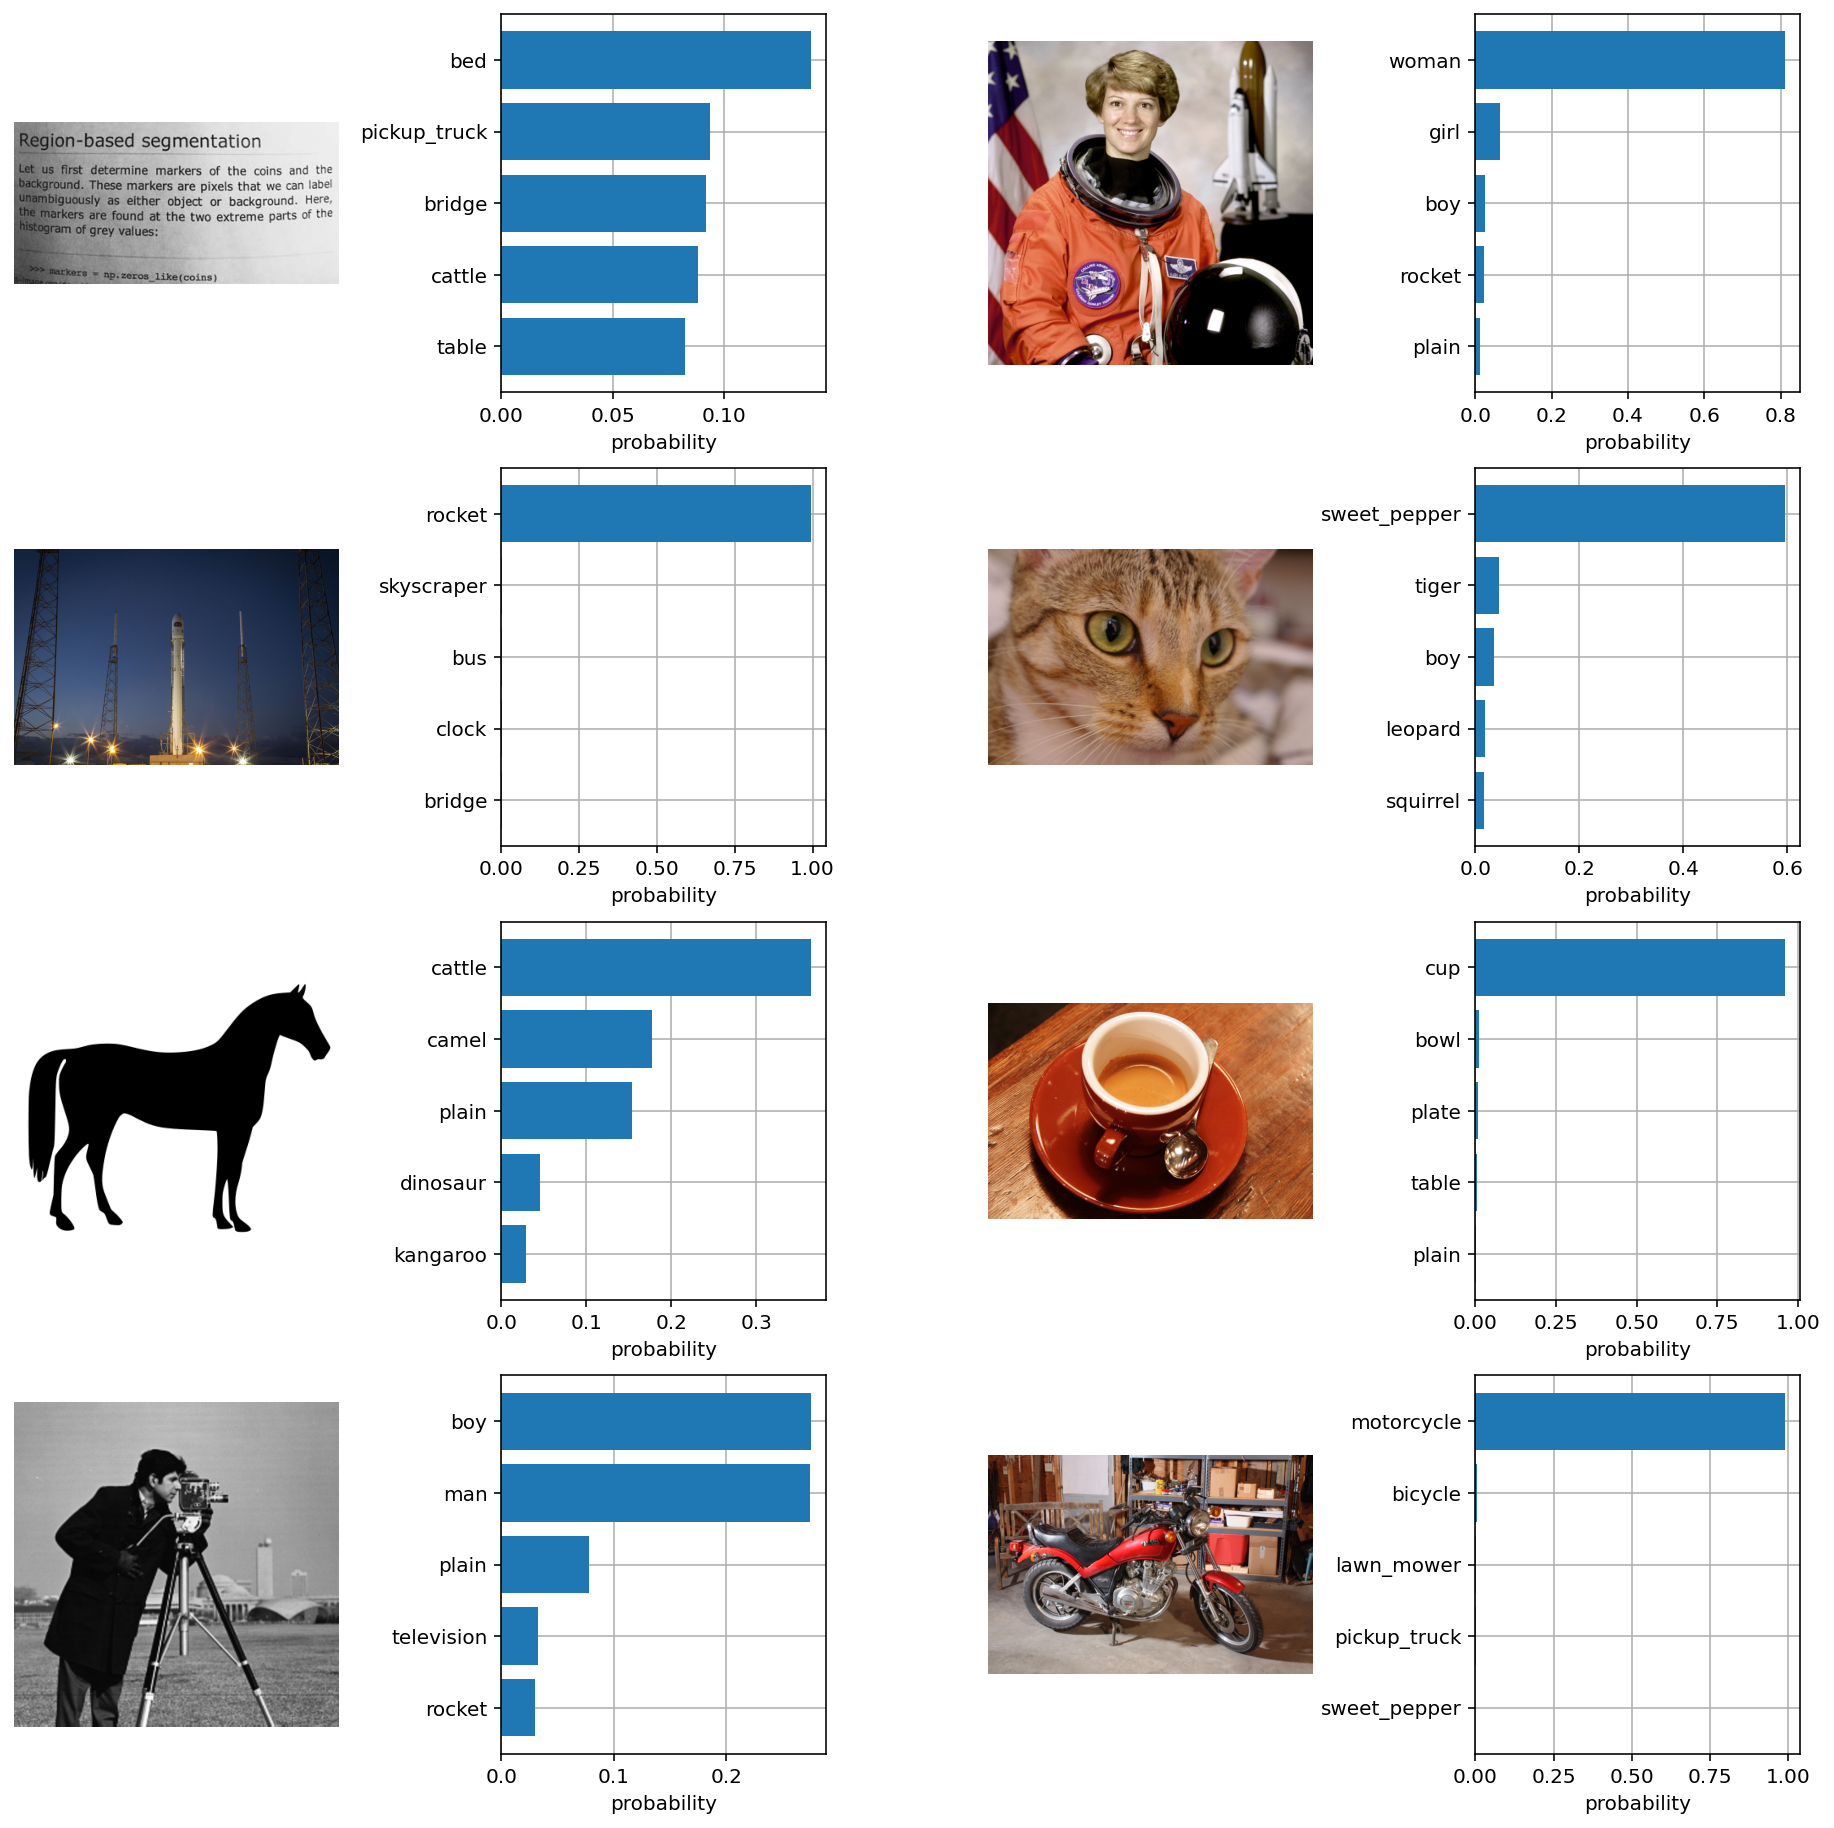

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()